# 1. Importação das bibliotecas necessarias

In [1]:
#Author: Yousef Mohamed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# 2. Leitura e processamento de dados

### 2.1 Lendo os dados

In [2]:
df = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/train.txt",
                 delimiter=';', header=None, names=['sentence','label'])

val_df = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/val.txt",
                 delimiter=';', header=None, names=['sentence','label'])

ts_df = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/test.txt",
                 delimiter=';', header=None, names=['sentence','label'])

In [3]:
df

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [4]:
df['label'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [5]:
df.label.value_counts()

label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

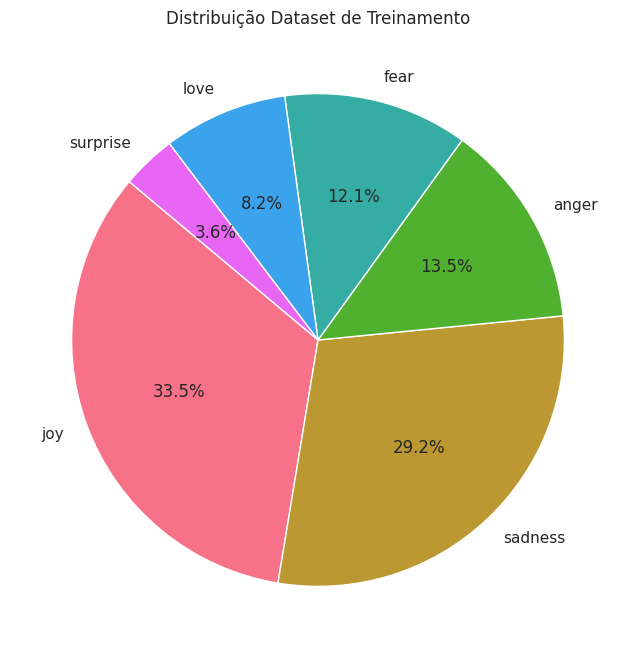

In [6]:
# Count label distributions
label_counts = df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Distribuição Dataset de Treinamento')
plt.show()

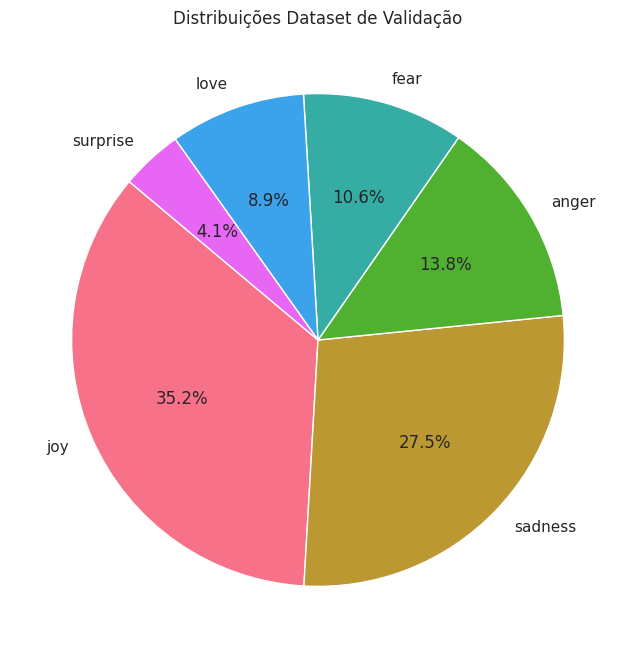

In [7]:
label_counts = val_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Distribuições Dataset de Validação')
plt.show()

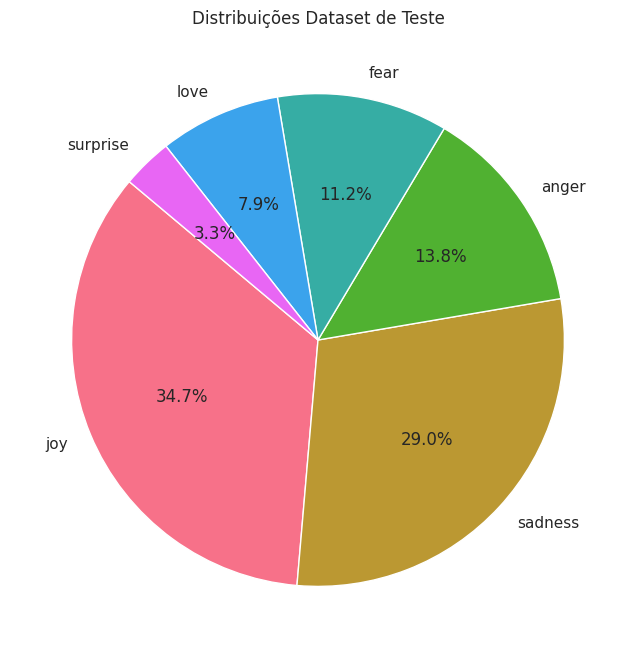

In [8]:
# Count label distributions
label_counts = ts_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Distribuições Dataset de Teste')
plt.show()

### Como temos um conjunto de dados desequilibrado, podemos remover os rótulos surpresa e amor, uma vez que são os mais baixos, e reduzir cada rótulo para tornar o conjunto de dados equilibrado.

In [9]:
df = df[~df['label'].str.contains('love')]
df = df[~df['label'].str.contains('surprise')]

In [10]:
joy = df[df['label'] == 'joy'].sample(n=2200, random_state=20)
sad = df[df['label'] == 'sadness'].sample(n=2200, random_state=20)
fear = df[df['label'] == 'fear'].sample(n=1937, random_state=20)
anger = df[df['label'] == 'anger'].sample(n=2159, random_state=20)

df_sampled = pd.concat([joy, sad, fear, anger])

df = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

In [11]:
df.label.value_counts()

label
joy        2200
sadness    2200
anger      2159
fear       1937
Name: count, dtype: int64

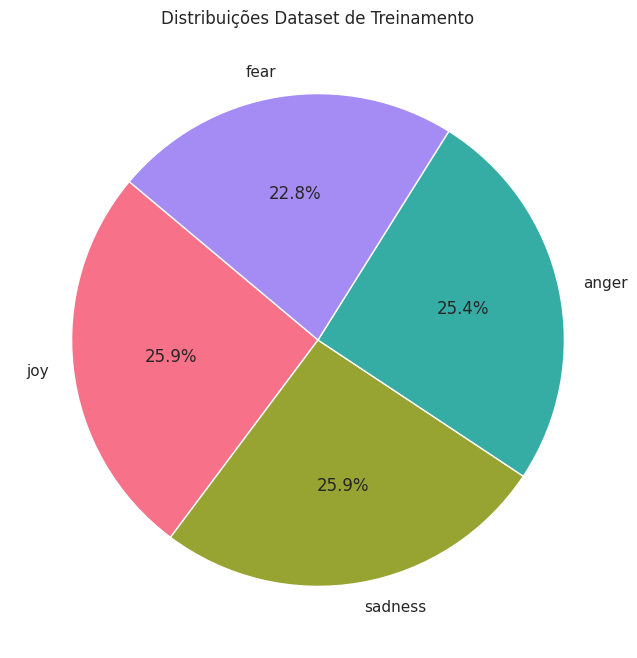

In [12]:
# Distribuições de etiquetas de contagem
label_counts = df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Distribuições Dataset de Treinamento')
plt.show()

In [13]:
val_df.label.value_counts()

label
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64

In [14]:
val_df = val_df[~val_df['label'].str.contains('love')]
val_df = val_df[~val_df['label'].str.contains('surprise')]

In [15]:
joy = val_df[val_df['label'] == 'joy'].sample(n=250, random_state=20)
sad = val_df[val_df['label'] == 'sadness'].sample(n=250, random_state=20)
fear = val_df[val_df['label'] == 'fear'].sample(n=212, random_state=20)
anger = val_df[val_df['label'] == 'anger'].sample(n=275, random_state=20)

df_sampled = pd.concat([joy, sad, fear, anger])

val_df = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

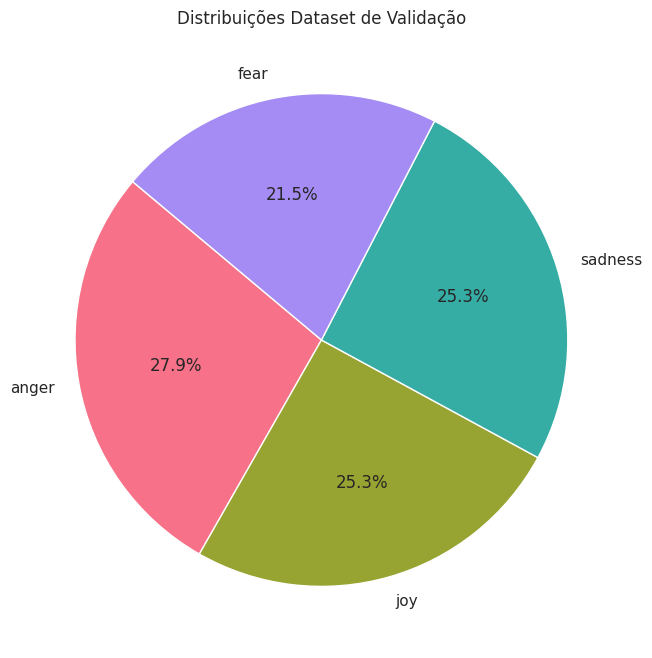

In [16]:
# Count label distributions
label_counts = val_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Distribuições Dataset de Validação')
plt.show()

In [17]:
ts_df.label.value_counts()

label
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

In [18]:
ts_df = ts_df[~ts_df['label'].str.contains('love')]
ts_df = ts_df[~ts_df['label'].str.contains('surprise')]

In [19]:
joy = ts_df[ts_df['label'] == 'joy'].sample(n=250, random_state=20)
sad = ts_df[ts_df['label'] == 'sadness'].sample(n=250, random_state=20)
fear = ts_df[ts_df['label'] == 'fear'].sample(n=224, random_state=20)
anger = ts_df[ts_df['label'] == 'anger'].sample(n=275, random_state=20)

df_sampled = pd.concat([joy, sad, fear, anger])

ts_df = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

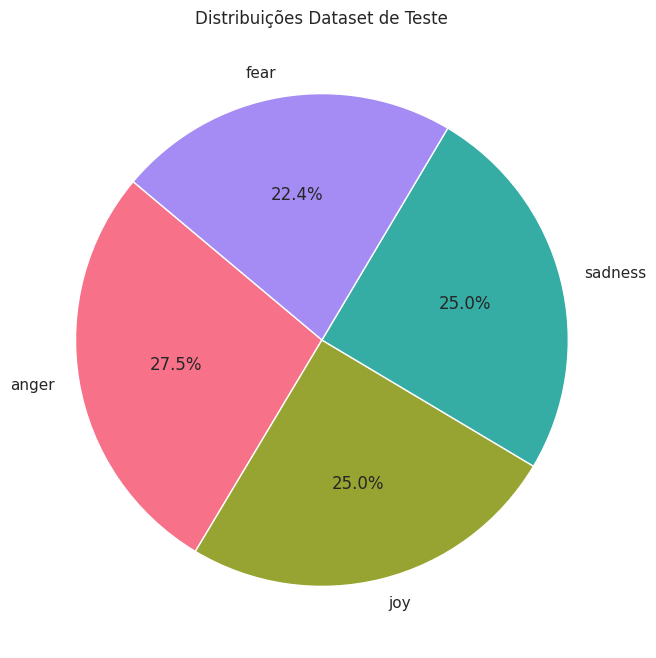

In [20]:
# Count label distributions
label_counts = ts_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Distribuições Dataset de Teste')
plt.show()

### 2.2 Dividir os dados em X, y

In [50]:
tr_text = df['sentence']
tr_label = df['label']

val_text = val_df['sentence']
val_label = val_df['label']

ts_text = ts_df['sentence']
ts_label = ts_df['label']

### 2.3 Codificação

In [22]:
encoder = LabelEncoder()
tr_label = encoder.fit_transform(tr_label)
val_label = encoder.transform(val_label)
ts_label = encoder.transform(ts_label)

### 2.4 Pré-processamento de texto

In [23]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tr_text) 
                            
sequences = tokenizer.texts_to_sequences(tr_text)

tr_x = pad_sequences(sequences, maxlen=50) 
tr_y = to_categorical(tr_label)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=50)
val_y = to_categorical(val_label)

sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=50)
ts_y = to_categorical(ts_label)

# 3. Construir um modelo de aprendizagem profunda

In [24]:
max_words = 10000
max_len = 50
embedding_dim = 32

### 3.1 Arquitetura do modelo

In [25]:
# Branch 1
branch1 = Sequential()
branch1.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch1.add(Conv1D(64, 3, padding='same', activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.5))
branch1.add(GlobalMaxPooling1D())

# Branch 2
branch2 = Sequential()
branch2.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch2.add(Conv1D(64, 3, padding='same', activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.5))
branch2.add(GlobalMaxPooling1D())

concatenated = Concatenate()([branch1.output, branch2.output])

hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.3)(hid_layer)
output_layer = Dense(4, activation='softmax')(dropout)

model = Model(inputs=[branch1.input, branch2.input], outputs=output_layer)

In [26]:
# model = Sequential()     
# model.add(Embedding(10000, 32, input_length=50))
# model.add(Conv1D(64, 3, padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(ReLU())
# model.add(Dropout(.5))
# model.add(GlobalMaxPooling1D(keepdims=True))
# model.add(Conv1D(64, 3, padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(ReLU())
# model.add(Dropout(.5))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(.5))
# model.add(Dense(6, activation='softmax'))

### 3.2 Compilar modelo

In [27]:
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_input (InputLaye  [(None, 50)]                 0         []                            
 r)                                                                                               
                                                                                                  
 embedding_1_input (InputLa  [(None, 50)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 embedding (Embedding)       (None, 50, 32)               320000    ['embedding_input[0][0]']     
                                                                                              

In [28]:
# GlobalMaxPooling1D??

### 3.3 Transformação do modelo

In [29]:
batch_size = 256
epochs = 25
history = model.fit([tr_x, tr_x], tr_y, epochs=epochs, batch_size=batch_size,
                    validation_data=([val_x, val_x], val_y))

Epoch 1/25
34/34 [==============================] - 5s 68ms/step - loss: 1.7531 - accuracy: 0.2564 - precision: 0.2520 - recall: 0.1112 - val_loss: 1.3866 - val_accuracy: 0.2472 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
34/34 [==============================] - 2s 52ms/step - loss: 1.4001 - accuracy: 0.3136 - precision: 0.3929 - recall: 0.0561 - val_loss: 1.3855 - val_accuracy: 0.2776 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
34/34 [==============================] - 2s 52ms/step - loss: 1.3308 - accuracy: 0.3591 - precision: 0.5332 - recall: 0.0444 - val_loss: 1.3844 - val_accuracy: 0.2958 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
34/34 [==============================] - 2s 65ms/step - loss: 1.2858 - accuracy: 0.3994 - precision: 0.6193 - recall: 0.0611 - val_loss: 1.3815 - val_accuracy: 0.3779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
34/34 [==============================] - 2s 62ms/step - loss: 1.2

# 4. Avaliação e visualização de resultados

### 4.1 Avaliar o modelo

In [30]:
(loss, accuracy, percision, recall) = model.evaluate([tr_x, tr_x], tr_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

266/266 [==============================] - 1s 4ms/step - loss: 0.0613 - accuracy: 0.9914 - precision: 0.9922 - recall: 0.9893
Loss: 0.06, Accuracy: 0.99, Precision: 0.99, Recall: 0.99


In [31]:
(loss, accuracy, percision, recall) = model.evaluate([ts_x, ts_x], ts_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

32/32 [==============================] - 0s 4ms/step - loss: 0.2018 - accuracy: 0.9379 - precision: 0.9503 - recall: 0.9179
Loss: 0.2, Accuracy: 0.94, Precision: 0.95, Recall: 0.92


In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

### 4.2 Resultados de visulização

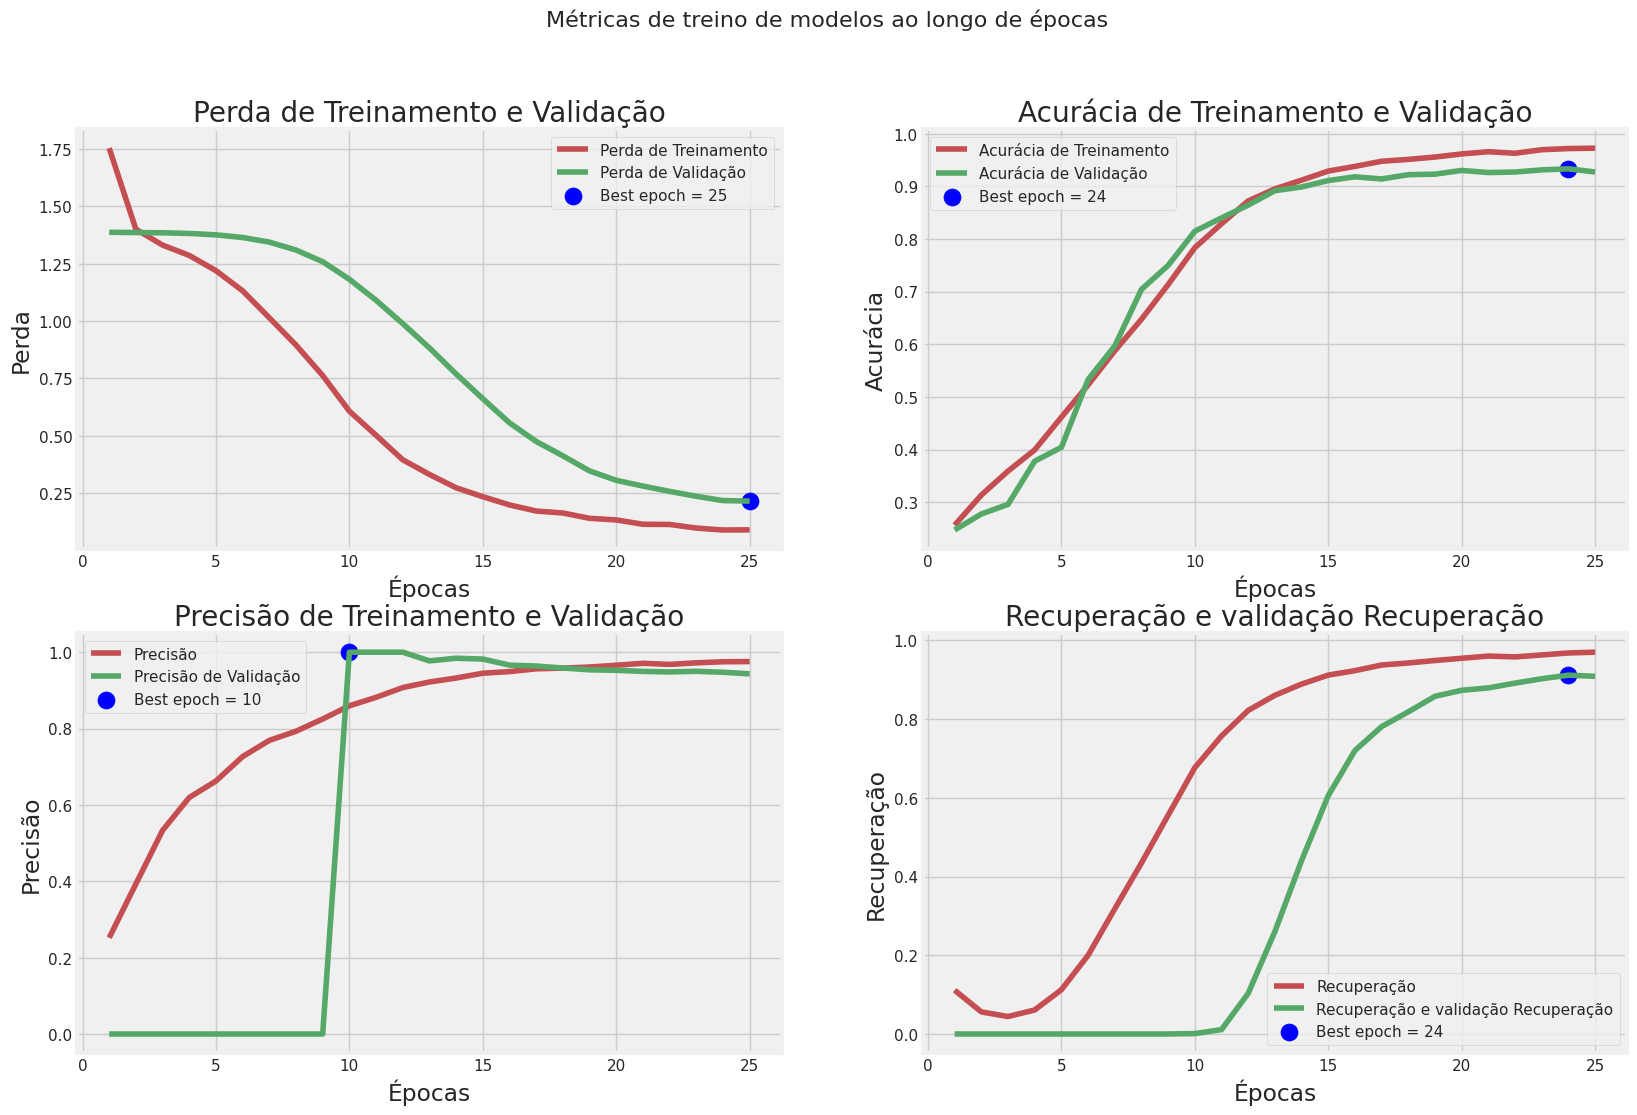

In [33]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
tr_per = history.history['precision']
tr_recall = history.history['recall']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_per = history.history['val_precision']
val_recall = history.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]


Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Perda de Treinamento')
plt.plot(Epochs, val_loss, 'g', label='Perda de Validação')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Perda de Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Acurácia de Treinamento')
plt.plot(Epochs, val_acc, 'g', label='Acurácia de Validação')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Acurácia de Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precisão')
plt.plot(Epochs, val_per, 'g', label='Precisão de Validação')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precisão de Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recuperação')
plt.plot(Epochs, val_recall, 'g', label='Recuperação e validação Recuperação')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recuperação e validação Recuperação')
plt.xlabel('Épocas')
plt.ylabel('Recuperação')
plt.legend()
plt.grid(True)

plt.suptitle('Métricas de treino de modelos ao longo de épocas', fontsize=16)
plt.show()

In [34]:
y_true=[]
for i in range(len(ts_y)):
    
    x = np.argmax(ts_y[i]) 
    y_true.append(x)

In [35]:
preds = model.predict([ts_x, ts_x])
y_pred = np.argmax(preds, axis=1)
y_pred

32/32 [==============================] - 0s 4ms/step


array([0, 1, 0, 2, 0, 3, 1, 2, 0, 3, 0, 0, 1, 1, 3, 1, 2, 2, 3, 2, 1, 0,
       2, 0, 3, 3, 1, 0, 2, 0, 2, 3, 1, 1, 3, 0, 2, 0, 3, 1, 3, 2, 1, 0,
       0, 2, 0, 3, 1, 2, 0, 3, 0, 2, 2, 2, 1, 1, 3, 2, 0, 1, 3, 3, 1, 2,
       0, 3, 0, 3, 1, 0, 1, 1, 1, 3, 0, 3, 0, 2, 2, 0, 1, 3, 0, 3, 0, 0,
       2, 2, 0, 2, 3, 1, 2, 2, 2, 3, 3, 1, 2, 2, 3, 1, 1, 2, 3, 0, 2, 1,
       1, 2, 0, 0, 3, 1, 3, 3, 0, 2, 2, 0, 0, 0, 1, 0, 1, 0, 0, 1, 2, 1,
       0, 1, 2, 2, 3, 3, 3, 1, 0, 3, 3, 1, 3, 0, 0, 0, 0, 2, 3, 1, 3, 3,
       3, 2, 3, 3, 0, 3, 1, 3, 1, 2, 3, 0, 1, 1, 1, 0, 2, 3, 1, 0, 2, 3,
       2, 2, 1, 2, 0, 0, 2, 0, 0, 0, 3, 3, 2, 2, 2, 1, 1, 3, 2, 2, 3, 1,
       1, 0, 1, 0, 2, 0, 3, 0, 2, 2, 0, 3, 3, 1, 3, 2, 0, 1, 2, 1, 3, 3,
       0, 2, 1, 2, 1, 0, 3, 3, 1, 3, 1, 0, 3, 1, 3, 1, 0, 0, 0, 3, 3, 2,
       0, 3, 1, 3, 2, 0, 1, 2, 0, 0, 3, 1, 1, 2, 1, 3, 0, 3, 0, 0, 2, 2,
       0, 0, 2, 0, 2, 1, 2, 1, 2, 2, 1, 2, 3, 2, 2, 0, 1, 1, 3, 1, 3, 0,
       2, 1, 1, 0, 1, 1, 3, 3, 2, 1, 1, 1, 0, 2, 2,

<Axes: >

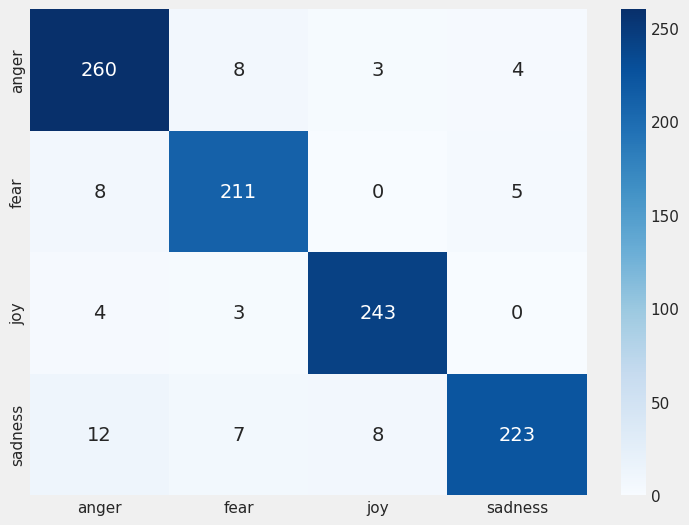

In [36]:
plt.figure(figsize=(8,6))
emotions = {0: 'anger', 1: 'fear', 2: 'joy', 3:'sadness'}
emotions = list(emotions.values())
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)

In [37]:
clr = classification_report(y_true, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       275
           1       0.92      0.94      0.93       224
           2       0.96      0.97      0.96       250
           3       0.96      0.89      0.93       250

    accuracy                           0.94       999
   macro avg       0.94      0.94      0.94       999
weighted avg       0.94      0.94      0.94       999



# 5. Salvar modelo

In [38]:
import pickle
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# model.save('nlp.h5')
#Recomendação do Keras para salvar no novo formato
model.save('nlp.keras')

# 6. Função de previsão

In [39]:
def predict(text, model_path, token_path):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    import matplotlib.pyplot as plt
    import pickle
    from tensorflow.keras.models import load_model
    
    model = load_model(model_path)
    
    
    with open(token_path, 'rb') as f:
        tokenizer = pickle.load(f)
    
    sequences = tokenizer.texts_to_sequences([text])
    x_new = pad_sequences(sequences, maxlen=50)
    predictions = model.predict([x_new, x_new])
    
    emotions = {0: 'anger', 1: 'fear', 2: 'joy', 3:'sadness'}
    
    label = list(emotions.values())
    probs = list(predictions[0])
    labels = label
    plt.subplot(1, 1, 1)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probabilidade', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 [==============================] - 0s 149ms/step


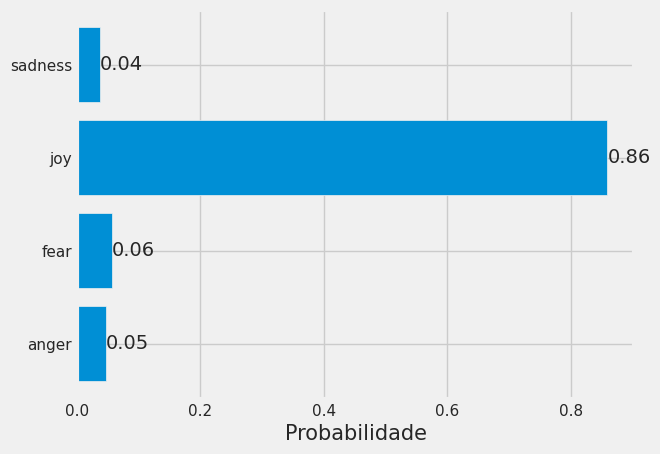

In [40]:
txt = 'I am very happy to finish this project'
predict(txt, 'nlp.keras', 'tokenizer.pkl')

1/1 [==============================] - 0s 146ms/step


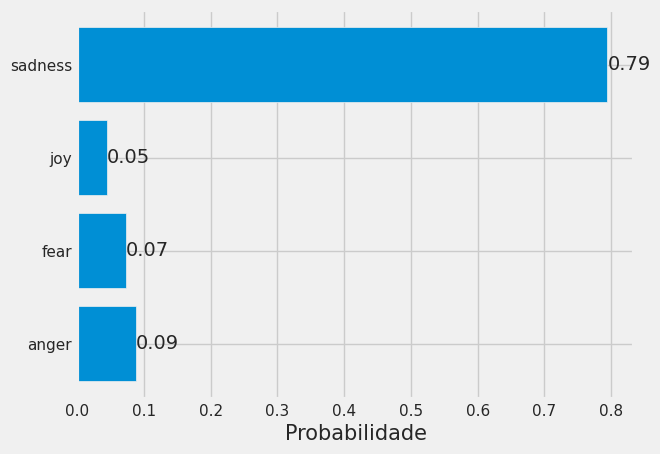

In [41]:
txt = 'I am very sad'
predict(txt, 'nlp.keras', 'tokenizer.pkl')

1/1 [==============================] - 0s 151ms/step


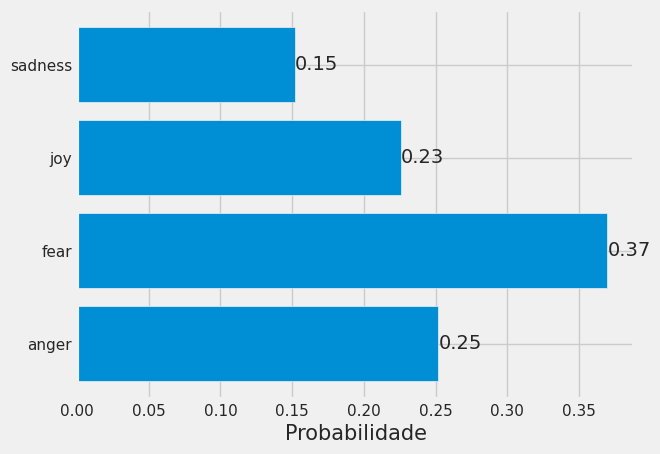

In [42]:
txt = 'Ahhhhhhhhhhhh, I wanna kill myself.'
predict(txt, 'nlp.keras', 'tokenizer.pkl')

1/1 [==============================] - 0s 160ms/step


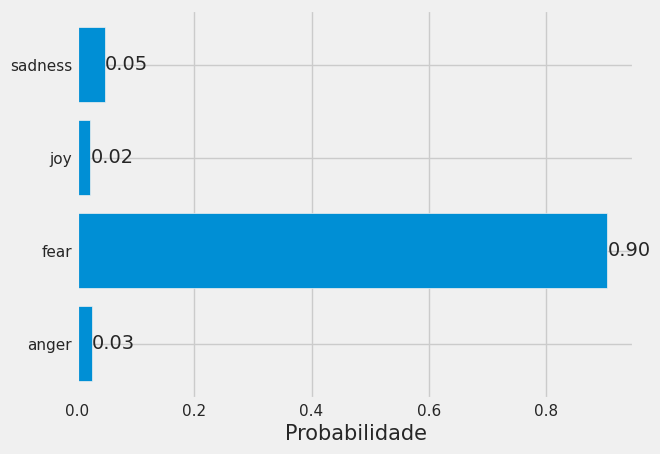

In [43]:
txt = 'I think, i am afraid.'
predict(txt, 'nlp.keras', 'tokenizer.pkl')